In [1]:
#起手式
import numpy as np 
import math
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import timm
from torchvision import transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR
from torch.optim.lr_scheduler import SequentialLR

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from PIL import Image

import warnings
warnings.filterwarnings("ignore") # 忽略所有警告

#随机种子
def set_seed(seed):
    seed = int(seed)
    if seed < 0 or seed > (2**32 - 1):
        raise ValueError("Seed must be between 0 and 2**32 - 1")
    else:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
set_seed(16)

#当前设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'使用{device}训练')



/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

使用cuda训练


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomRotation([90, 90])], p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.Normalize(mean=(0.485,0.456,0.406),
                         std=(0.229,0.224,0.225)),
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406),
                         std=(0.229,0.224,0.225)),
])
class Dataset():
    def __init__(self, df, transform,transform_test, scaler_target,transform_type):
        self.samples = list(df.itertuples(index=False))
        self.image_dir = "/kaggle/input/csiro-biomass"
        self.targets = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']
        self.transform = transform
        self.transform_test = transform_test
        self.scaler_target = scaler_target
        self.transform_type = transform_type
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        row = self.samples[idx]
        
        img_path = os.path.join(self.image_dir, row.image_path)
        image = Image.open(img_path).convert("RGB")
        if self.transform_type == 'train':
            image = self.transform(image)
        if self.transform_type == 'test':
            image = self.transform_test(image)

        target = torch.tensor([getattr(row, t) for t in self.targets], dtype=torch.float32)
        target = torch.tensor(self.scaler_target.transform([target.numpy()])[0], dtype=torch.float32)

        return image, target

文件读取成功 target_name              image_path  Dry_Clover_g  Dry_Dead_g  Dry_Green_g  \
0            train/ID1011485656.jpg        0.0000     31.9984      16.2751   
1            train/ID1012260530.jpg        0.0000      0.0000       7.6000   
2            train/ID1025234388.jpg        6.0500      0.0000       0.0000   
3            train/ID1028611175.jpg        0.0000     30.9703      24.2376   
4            train/ID1035947949.jpg        0.4343     23.2239      10.5261   

target_name  Dry_Total_g    GDM_g  
0                48.2735  16.2750  
1                 7.6000   7.6000  
2                 6.0500   6.0500  
3                55.2079  24.2376  
4                34.1844  10.9605  


Text(0.5, 1.0, 'Dry_Dead_g')

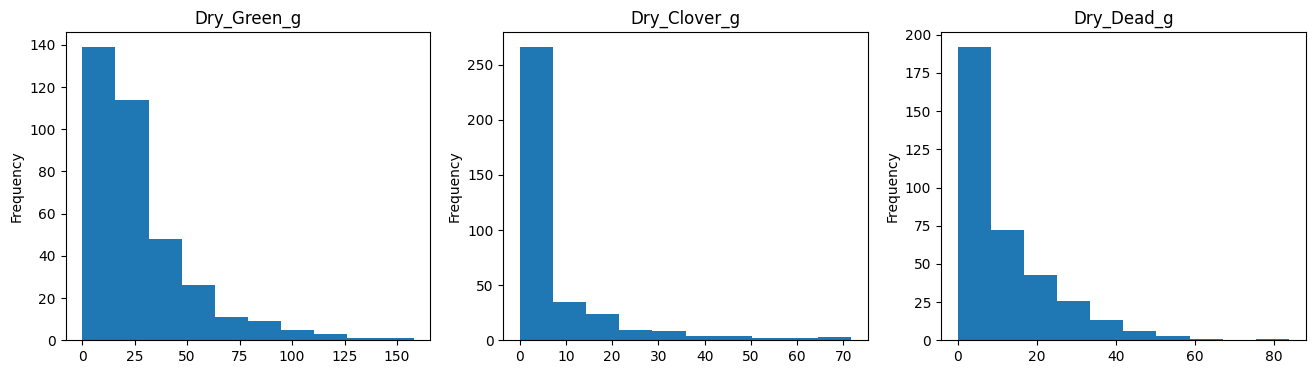

In [3]:
#读取文件 并统计图片对应标签值
df = pd.read_csv("/kaggle/input/csiro-biomass/train.csv")
df = df[["image_path", "target_name", "target"]]
df = df.pivot_table(index=["image_path"],columns='target_name',values="target").reset_index()
print('文件读取成功',df.head(5))

#转换结构 列为target_name 值为target

#df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# 目标值缩放 避免梯度爆炸
scaler_target = StandardScaler()
targets=['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']
scaler_target.fit(df[targets].values)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
df.Dry_Green_g.plot(kind='hist')
plt.title('Dry_Green_g')

plt.subplot(1, 3, 2)
df.Dry_Clover_g.plot(kind='hist')
plt.title('Dry_Clover_g')

plt.subplot(1, 3, 3)
df.Dry_Dead_g.plot(kind='hist')
plt.title('Dry_Dead_g')

In [4]:
#模型
class ViTBase16(nn.Module):
    def __init__(self):

        super(ViTBase16, self).__init__()

        # # 加载权重
        self.model = timm.create_model('vit_base_patch16_224', pretrained=False)
        self.model.head = nn.Linear(self.model.head.in_features, 5)
        state_dict = torch.load('/kaggle/input/vision-transformer-vit-tutorial-baseline/model_5e_20201202-1908.pth')
        state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
        self.model.load_state_dict(state_dict)
        

    def forward(self, x):
        x = self.model(x)
        return x


In [5]:
#模型评估
def calc_metric(outputs, targets):
    '''
        outputs/targets: shape (N, 3): Green/Clover/Dead
    '''
    y_true = np.column_stack((
        targets,
        targets[:, :2].sum(axis=1),
        targets.sum(axis=1),
    ))
    
    y_pred = np.column_stack((
        outputs,
        outputs[:, :2].sum(axis=1),
        outputs.sum(axis=1),
    ))
    
    weighted_r2, r2_scores = weighted_r2_score(y_true, y_pred)
    return weighted_r2, r2_scores
    
# ======== Weighted R² ========
def weighted_r2_score(y_true: np.ndarray, y_pred: np.ndarray):
    """
    y_true, y_pred: shape (N, 5): Green/Clover/Dead/GDM/Total
    """
    weights = np.array([0.1, 0.1, 0.1, 0.2, 0.5])
    r2_scores = []
    for i in range(5):
        y_t = y_true[:, i]
        y_p = y_pred[:, i]
        ss_res = np.sum((y_t - y_p) ** 2)
        ss_tot = np.sum((y_t - np.mean(y_t)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0.0
        r2_scores.append(r2)
    r2_scores = np.array(r2_scores)
    weighted_r2 = np.sum(r2_scores * weights) / np.sum(weights)
    return weighted_r2, r2_scores

In [6]:
class Full():
    def __init__(self,df,scaler_target,loss_fn,optimizer):
        #super().__init__()
        self.df = df
        self.scaler_target = scaler_target
        #self.model=model
        # self.loader=loader
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        
    def train(self,model,train_dataloader):
        #混合精度
        from torch.amp import autocast, GradScaler 
        scaler = GradScaler()
        #print("启用混合精度训练")
        model.train()
        loss_sum = 0.0
    
        for x , Y in train_dataloader:
            x , Y= x.to(device) , Y.to(device)
    
            self.optimizer.zero_grad()
            with autocast(device):
                pred = model(x)
                loss = self.loss_fn(pred, Y)
                #print(loss)
            scaler.scale(loss).backward() 
            scaler.step(self.optimizer)
            scaler.update()
            
            loss_sum += loss.item()

        return loss_sum / len(train_dataloader)
        
    def test(self,model,test_dataloader):
        model.eval()
        loss_sum = 0.0
        all_pred=[]
        all_target=[]
        with torch.no_grad():
            for x , Y in test_dataloader:
                x , Y= x.to(device),Y.to(device)
                
                pred = model(x)
       
                loss = self.loss_fn(pred, Y)
                loss_sum += loss.item()

                all_pred.append(pred.detach().cpu())
                all_target.append(Y.detach().cpu())
        #评估
        outputs = torch.cat(all_pred).numpy()
        targets = torch.cat(all_target).numpy()         
        
        weighted_r2, r2_scores=calc_metric(outputs, targets)
    
        return loss_sum / len(test_dataloader),weighted_r2
        
    def res(self,best_model,flod):
        df_test = pd.read_csv('/kaggle/input/csiro-biomass/test.csv')
        test_path = df_test["image_path"].values.tolist()
        test_target = df_test["target_name"].values.tolist()
        
        res = []
        # # 定义3种TTA变换
        # tta_transforms = [
        #     transforms.RandomHorizontalFlip(p=1.0),  # 强制水平翻转
        #     transforms.RandomVerticalFlip(p=1.0),    # 强制垂直翻转
        #     transforms.RandomRotation([90, 90])      # 旋转90度
        # ]
        # # 创建对应的transform组合
        # tta_transform_list = []
        # for tta_t in tta_transforms:
        #     # 带增强的transform
        #     transform_combo = transforms.Compose([
        #         transforms.Resize((224, 224)),
        #         tta_t,  # 添加TTA变换
        #         transforms.ToTensor(),
        #         transforms.Normalize(mean=(0.485,0.456,0.406),
        #                              std=(0.229,0.224,0.225)),
        #     ])
        #     tta_transform_list.append(transform_combo)
        # count=0
        with torch.no_grad():
            for img_path,target in zip(test_path,test_target):
                img_path = os.path.join('/kaggle/input/csiro-biomass', img_path)
                image = Image.open(img_path).convert("RGB")
                print(target)
                all_preds=[]
                #原图
                raw_image = transform_test(image).to(device).unsqueeze(0)
                preds = best_model(raw_image)
                # all_preds.append(pred.detach().cpu())

                # #TTA测试取平均
                # for transform_combo in tta_transform_list:
                #     tta_image = transform_combo(image).to(device).unsqueeze(0)
                #     pred = best_model(tta_image)
                #     all_preds.append(pred.detach().cpu())
                    
                # # 对4种预测结果取平均
                # preds = torch.mean(torch.stack(all_preds), dim=0)

                preds = self.scaler_target.inverse_transform(preds.detach().cpu())
                preds=preds.reshape(-1)

                if target == 'Dry_Clover_g':
                    res.append(preds[0])
                elif target == 'Dry_Dead_g':
                    res.append(preds[1])
                elif target == 'Dry_Green_g':
                    res.append(preds[2])
                elif target == 'Dry_Total_g':
                    res.append(preds[3])
                else: #GDM_g
                    res.append(preds[4])
       
            #输出
            submission = pd.DataFrame({'sample_id':df_test['sample_id'],'target':res})
            # submission.to_csv(f'submission-{flod}.csv', index = False)
            submission.to_csv(f'submission.csv', index = False)
            torch.save(best_model.state_dict(), f'VIT—CSIRO-{flod}')
            print(f"保存模型：VIT—CSIRO-{flod}")
            print(submission)
        
  

In [7]:
def dataloader(flod):
    batch_size = 64
    
    train_dataset = Dataset(df[df['fold']!=flod], transform, transform_test,scaler_target,'train')
    test_dataset = Dataset(df[df['fold']==flod], transform,transform_test, scaler_target,'test')
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
    test_dataloader = DataLoader(test_dataset,batch_size=batch_size,num_workers=2)
    
    return train_dataloader,test_dataloader

In [8]:
def train_flod(df,scaler_target,train_dataloader,test_dataloader,flod):
    #释放内存
    import gc
    
    torch.cuda.empty_cache()
    gc.collect()
    
    #定义模型
    model=ViTBase16()
    
    #多gpu运行
    model = model.to(device)
    if torch.cuda.device_count() > 1:
        print(f"使用 {torch.cuda.device_count()} 个GPU")
        model = torch.nn.DataParallel(model)
    else:
        model.to(device)
    
    #损失函数
    # loss_fn = nn.MSELoss()
    loss_fn=nn.SmoothL1Loss()
    epoch = 2

     #耐心
    n= 100
    print(f"早停耐心：{n}  | 学习率耐心: {0}")

    optimizer = optim.AdamW(model.parameters(),
                          lr=1e-3,              
                          weight_decay=5e-4
                         )
       
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode='max', factor=0.5, patience=3
    # )
    
    #余弦退火
    scheduler = CosineAnnealingLR(optimizer,
                                  T_max=epoch//2,
                                  eta_min=1e-10
                                 )
    
    best_model = model #最优模型
    
    train_loss_list=[]
    test_loss_list=[]
    lr_list=[]
    w_r2_list=[]

    
    min_R2 = -1*np.inf
    
    #训练
    full=Full(df,scaler_target,loss_fn,optimizer)
    
    for i in range(epoch):
        train_loss=full.train(model,train_dataloader)
        test_loss,weighted_r2=full.test(model,test_dataloader)
        
        # scheduler.step(weighted_r2)
        scheduler.step()  #余弦退火
        
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        w_r2_list.append(weighted_r2)
        lr_list.append(scheduler.get_last_lr()[0])
        
        if (i+1)%10==0:
            print(f"第{i+1}/{epoch}迭代 | 训练损失:{train_loss} | 测试损失值:{test_loss} | weighted_r2:{weighted_r2}")
            print(f'lr: {scheduler.get_last_lr()[0]:6f}')
        
        if min_R2 <= weighted_r2:
            min_R2 = weighted_r2
            best_model=model    #最优模型
            # n=10    #恢复耐心
              
        #减少耐心
        # else:n-=1
        # if n<=0:
        #     print(f'超过{{n}}epoch没有改善，早停')
        #     break
    #最优结果
    full.res(best_model,flod)
    
    #图片
    plt.figure(figsize=(20,15))
    
    plt.subplot(2,2,1)
    plt.plot(train_loss_list,color='red')#,label='train_loss'
    plt.plot(test_loss_list,color='green')#,label='test_loss'
    plt.title("loss")
    
    plt.subplot(2,2,2)
    plt.plot(lr_list)
    plt.title("lr")
    
    plt.subplot(2,2,3)
    plt.plot(w_r2_list)
    plt.title(weighted_r2)

    plt.show()

    print(f'{'-'*20}第{flod+1}折结束{'-'*20}')    



-----------------------------测试集合-----------------------------------



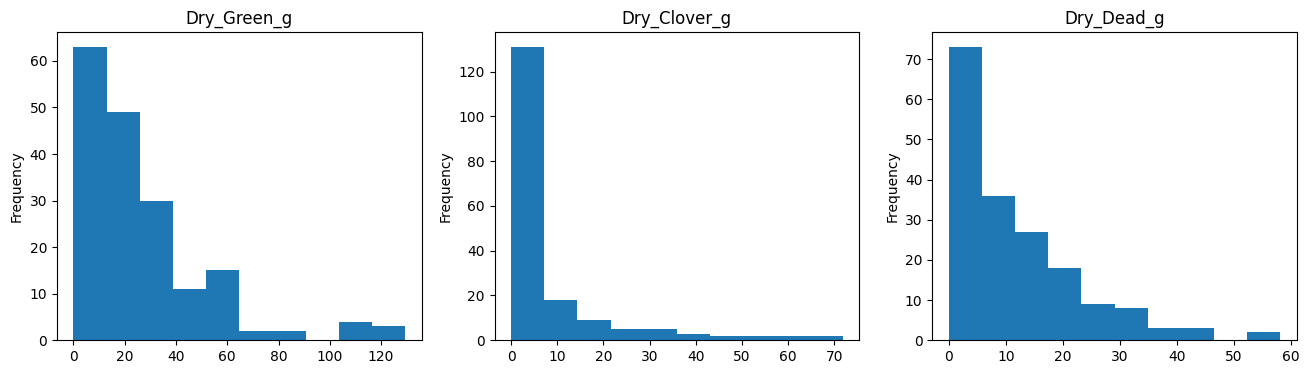

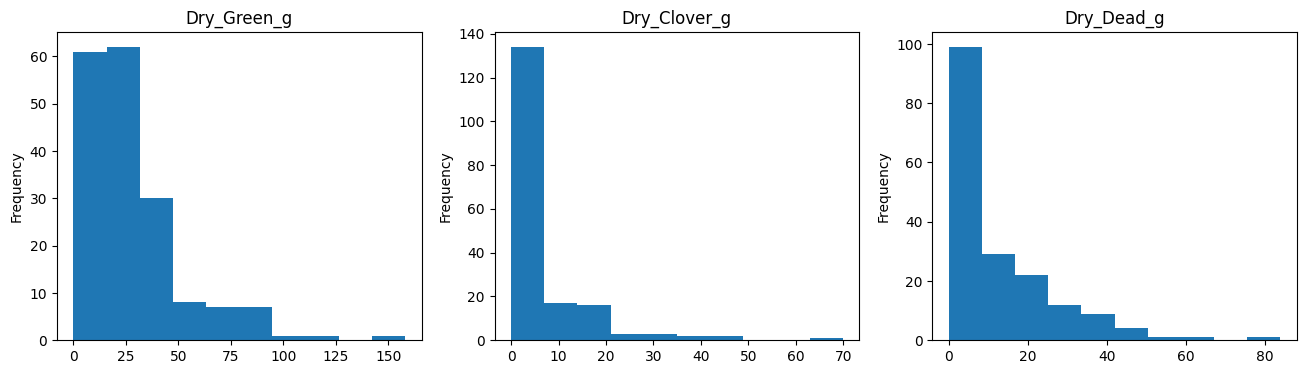

In [9]:
from sklearn.model_selection import KFold, GroupKFold, StratifiedGroupKFold
CV_STRATEGY ='random'
# NFOLD = 5
NFOLD = 2
KFoldClass = StratifiedGroupKFold if CV_STRATEGY == 'groupby_Sampling_Date' else KFold
kfold = KFoldClass(n_splits=NFOLD, shuffle=True, random_state=42)

# kfold = KFold(n_splits=NFOLD, shuffle=True, random_state=42)

df['fold'] = None
for i, (trn_idx, val_idx) in enumerate(kfold.split(df.index)):
    df.loc[val_idx, 'fold'] = i
    
#抽样结果统计

print("\n-----------------------------测试集合-----------------------------------\n")
for i in range(NFOLD):
    
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    df[df['fold']==i].Dry_Green_g.plot(kind='hist')
    plt.title('Dry_Green_g')
    
    plt.subplot(1, 3, 2)
    df[df['fold']==i].Dry_Clover_g.plot(kind='hist')
    plt.title('Dry_Clover_g')
    
    plt.subplot(1, 3, 3)
    df[df['fold']==i].Dry_Dead_g.plot(kind='hist')
    plt.title('Dry_Dead_g')


    


-----------------------------训练集合-----------------------------------



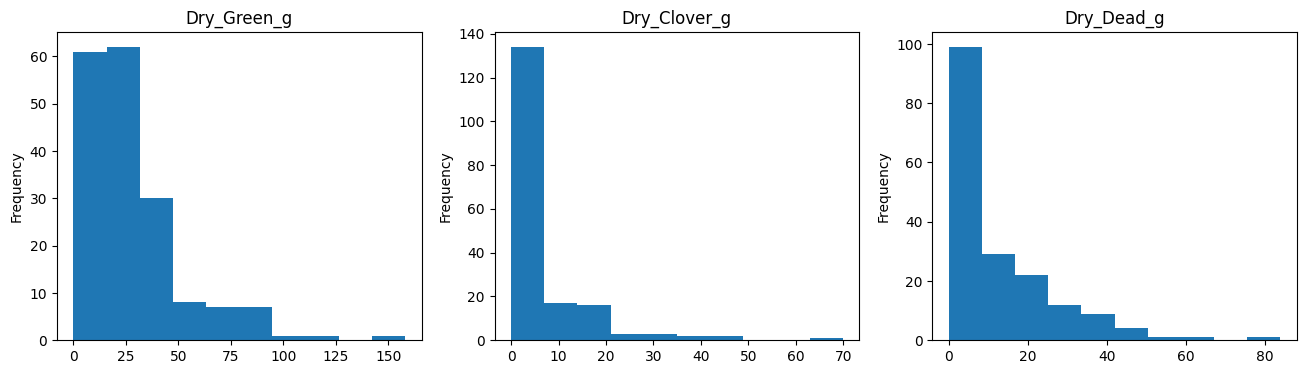

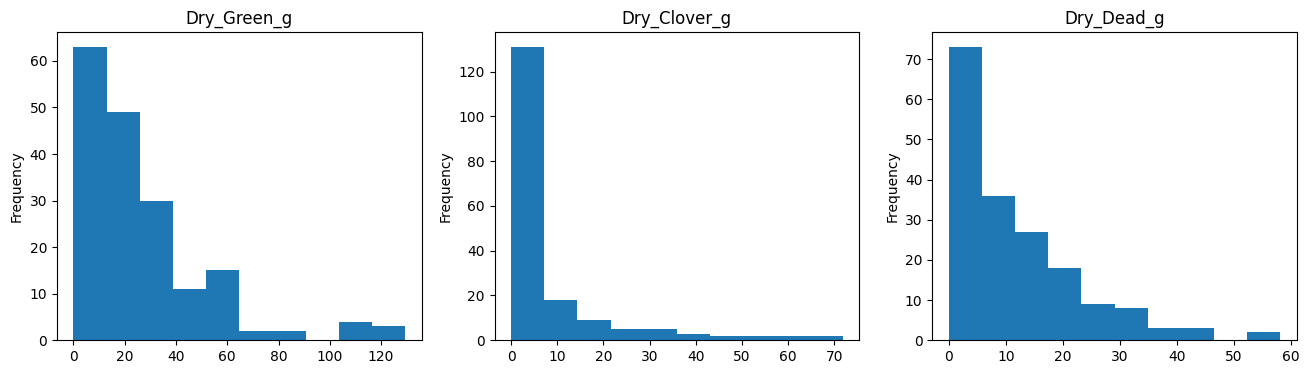

In [10]:
print("\n-----------------------------训练集合-----------------------------------\n")
for i in range(NFOLD):
    
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    df[df['fold']!=i].Dry_Green_g.plot(kind='hist')
    plt.title('Dry_Green_g')
    
    plt.subplot(1, 3, 2)
    df[df['fold']!=i].Dry_Clover_g.plot(kind='hist')
    plt.title('Dry_Clover_g')
    
    plt.subplot(1, 3, 3)
    df[df['fold']!=i].Dry_Dead_g.plot(kind='hist')
    plt.title('Dry_Dead_g')
    

使用 2 个GPU
早停耐心：100  | 学习率耐心: 0
Dry_Clover_g
Dry_Dead_g
Dry_Green_g
Dry_Total_g
GDM_g
保存模型：VIT—CSIRO-0
                    sample_id     target
0  ID1001187975__Dry_Clover_g   6.720445
1    ID1001187975__Dry_Dead_g  23.636875
2   ID1001187975__Dry_Green_g  31.786009
3   ID1001187975__Dry_Total_g  16.119296
4         ID1001187975__GDM_g  16.879154


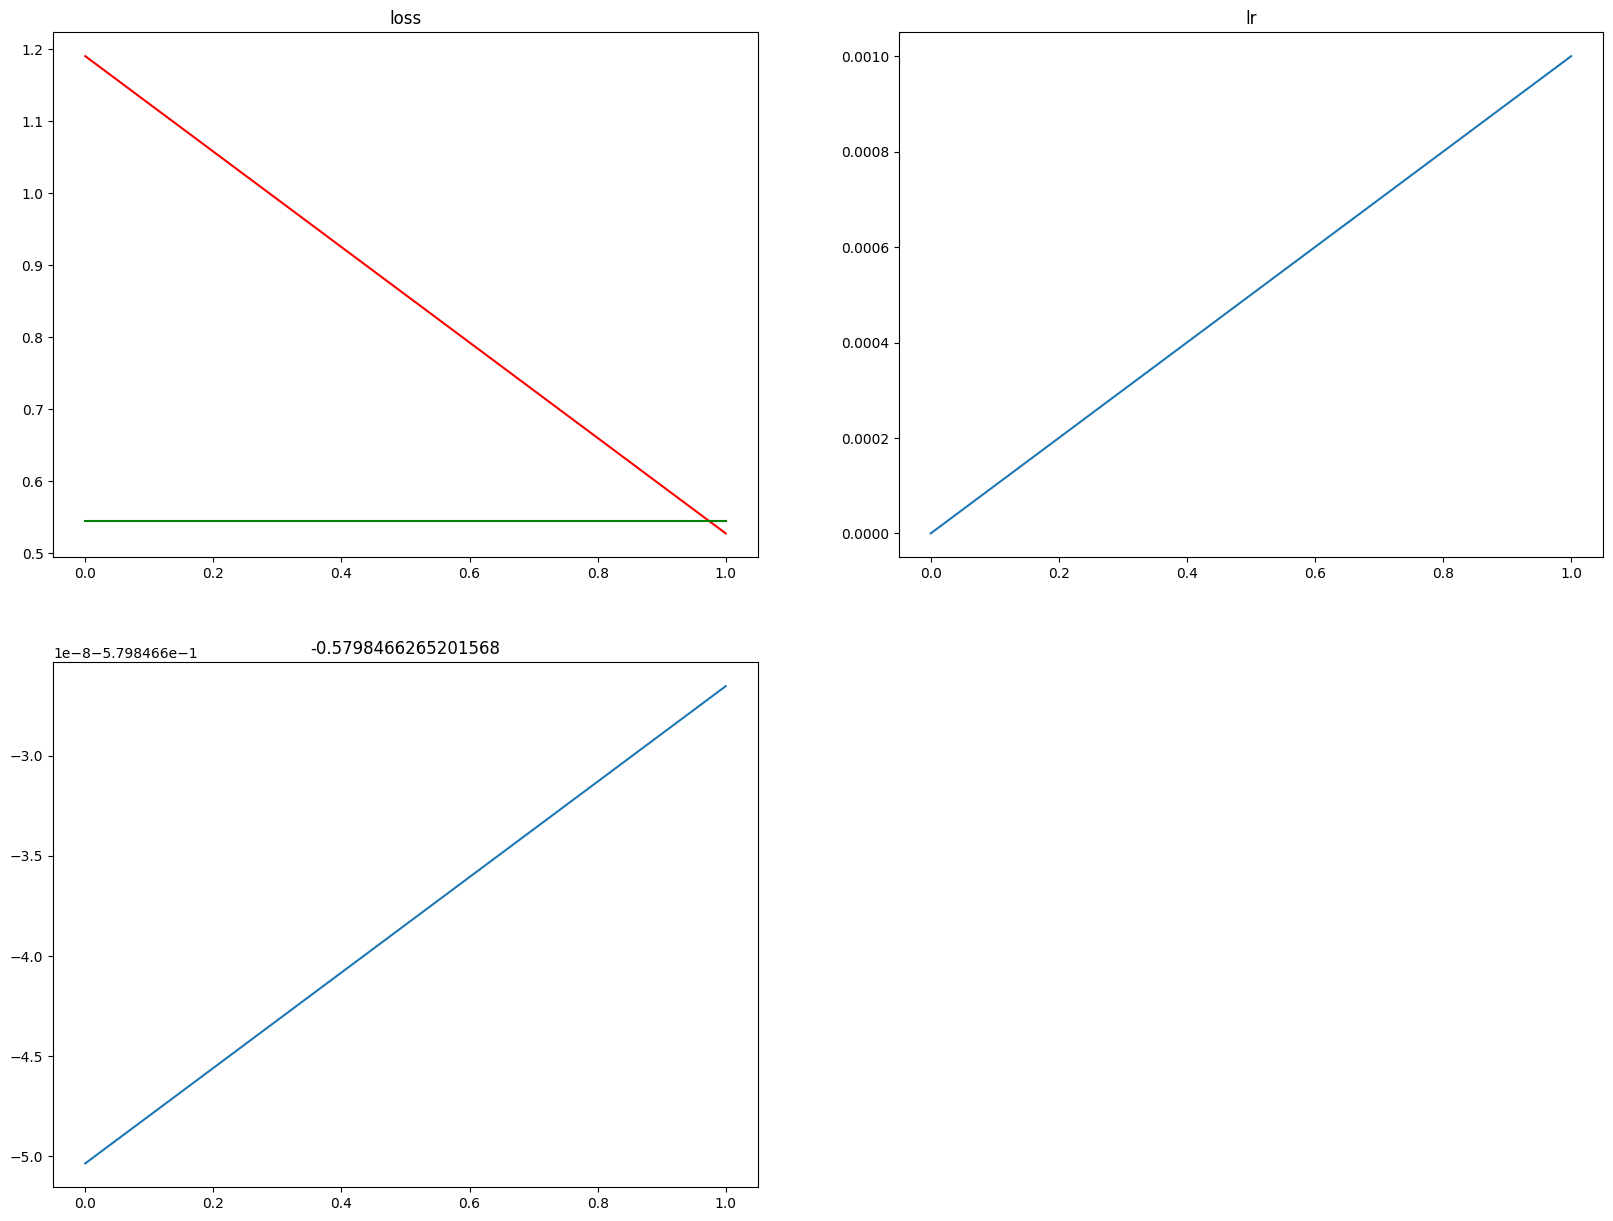

--------------------第1折结束--------------------
使用 2 个GPU
早停耐心：100  | 学习率耐心: 0
Dry_Clover_g
Dry_Dead_g
Dry_Green_g
Dry_Total_g
GDM_g
保存模型：VIT—CSIRO-1
                    sample_id     target
0  ID1001187975__Dry_Clover_g  11.704872
1    ID1001187975__Dry_Dead_g  24.654014
2   ID1001187975__Dry_Green_g  12.917838
3   ID1001187975__Dry_Total_g  32.709169
4         ID1001187975__GDM_g  62.528610


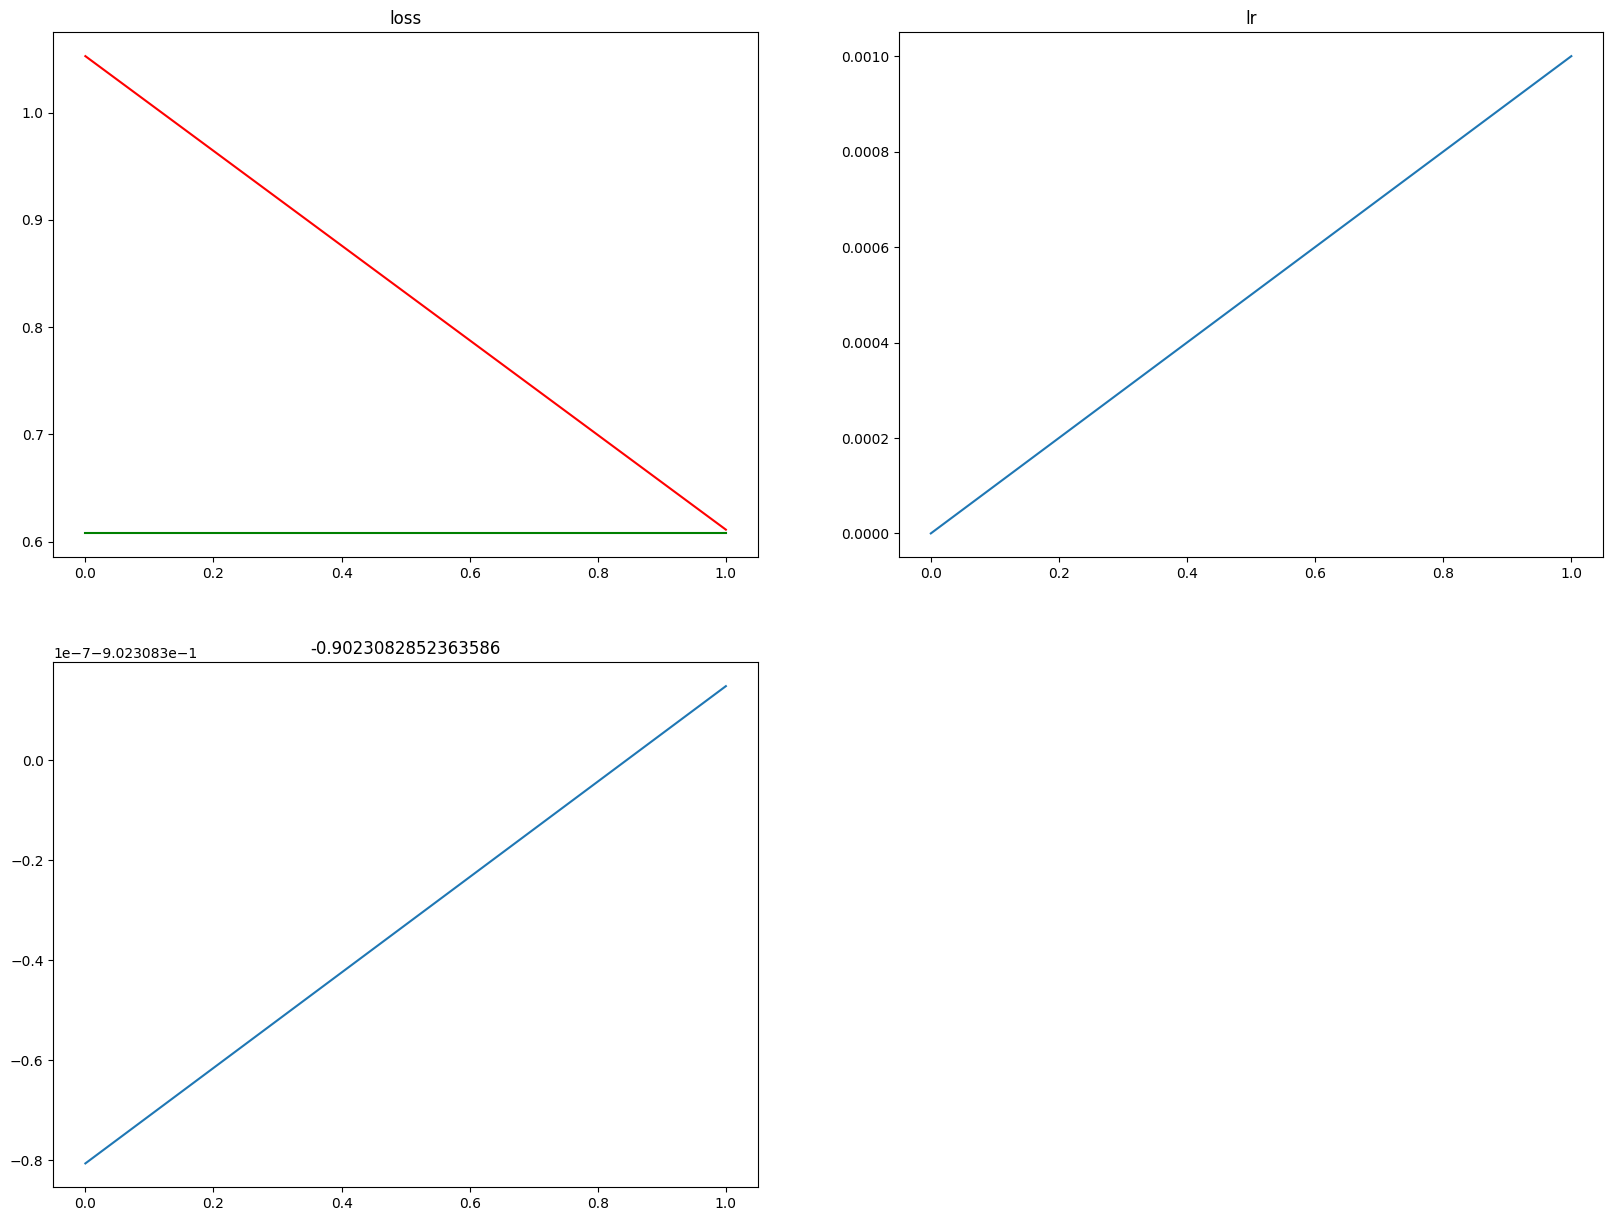

--------------------第2折结束--------------------


In [11]:

for i in range(NFOLD):

    train_dataloader,test_dataloader = dataloader(flod=i)
    train_flod(df,scaler_target,train_dataloader,test_dataloader,i)

    

In [12]:
# Clover =[]
# Dead = []
# Green = []
# Tota = []
# GDM = []
# for i in range(NFOLD):
#     p = pd.read_csv(f"/kaggle/working/submission-{i}.csv")
#     print(p)
#     Clover.append(float(p.loc[0,'target']))
#     Dead.append(float(p.loc[1,'target']))
#     Green.append(float(p.loc[2,'target']))
#     Tota.append(float(p.loc[3,'target']))
#     GDM.append(float(p.loc[4,'target']))
# #print(Clover,'\t',Dead,Green,Tota,GDM)
# value=[sum(Clover)/NFOLD,sum(Dead )/NFOLD,sum(Green)/NFOLD,sum(Tota)/NFOLD,sum(GDM)/NFOLD]
# print(value)


# res_cvs=pd.DataFrame({
#     'sample_id' : p['sample_id'],
#     'target' : value
# })
# res_cvs.to_csv(f'submission.csv', index = False)